In [30]:
!pip install --quiet aiohappyeyeballs aiohttp aiosignal annotated-types anyio argon2-cffi argon2-cffi-bindings arrow asttokens async-timeout attrs beautifulsoup4 bleach build certifi cffi charset-normalizer click comm dataclasses-json debugpy decorator defusedxml distro entrypoints exceptiongroup executing fastjsonschema fqdn frozenlist greenlet h11 httpcore httpx httpx-sse idna ipykernel ipython ipython-genutils isoduration jedi Jinja2 jiter jsonpatch jsonpointer jsonschema jsonschema-specifications jupyter_client jupyter_core jupyter-events jupyter_server jupyter_server_terminals jupyterlab_pygments langchain langchain-community langchain-core langchain-openai langchain-text-splitters langgraph langgraph-checkpoint langgraph-sdk langsmith MarkupSafe marshmallow matplotlib-inline mistune msgpack multidict mypy-extensions nbclassic nbclient nbconvert nbformat nest-asyncio notebook notebook_shim numpy openai orjson overrides packaging pandocfilters parso pexpect pip pip-tools platformdirs prometheus_client prompt_toolkit propcache psutil ptyprocess pure_eval pycparser pydantic pydantic_core pydantic-settings Pygments pyproject_hooks python-dateutil python-dotenv python-json-logger PyYAML pyzmq referencing regex requests requests-toolbelt rfc3339-validator rfc3986-validator rpds-py Send2Trash setuptools six sniffio soupsieve SQLAlchemy stack-data tenacity terminado tiktoken tinycss2 tomli tornado tqdm traitlets types-python-dateutil typing_extensions typing-inspect uri-template urllib3 wcwidth webcolors webencodings websocket-client wheel yarl sentence-transformers

In [31]:
from typing import Literal, List, Dict
import itertools
from langchain_core.embeddings import Embeddings
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [32]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')
OPENAI_API_BASE = "https://openai.vocareum.com/v1"
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

**Embeddings Intuition**

In [33]:
class EmbeddingsFactory:
    def __init__(self,
                 provider:Literal["OpenAI", "HugginFace"],
                 **kwargs):
        self.provider = provider
        self.kwargs = kwargs

    def create(self) -> Embeddings:
        if self.provider == "OpenAI":
            return OpenAIEmbeddings(**self.kwargs)
        if self.provider == "HugginFace":
            return HuggingFaceEmbeddings(**self.kwargs)
        raise ValueError(f"Unknown embeddings provider: {self.provider}")

In [34]:
sentence_list = [
    "I want to listen to music again",
    "I'm in the mood to hear music once more.",
    "Playstation has been a big part of my childhood",
    "I grew up playing Nintendo games",
    "The place I visited is the same as before",
    "The destination I returned to hasn’t changed over the years",
]

In [35]:
# HuggingFace
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
embeddings = EmbeddingsFactory(
    provider="HugginFace",
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    encode_kwargs={'normalize_embeddings': False}
).create()

In [36]:
# OpenAI
from dotenv import load_dotenv
load_dotenv()

embeddings = EmbeddingsFactory(
    provider="OpenAI",
    base_url=OPENAI_API_BASE,
    api_key=OPENAI_API_KEY
).create()

In [37]:
embeddings_list = [
    embeddings.embed_query(sentence)
    for sentence in sentence_list
]

In [38]:
len(embeddings_list)

6

In [39]:
len(embeddings_list[0])

1536

In [40]:
embeddings_list[0][:10]

[-0.006489809136837721,
 -0.007244148291647434,
 -0.003266724292188883,
 -0.02570986934006214,
 -0.01738096959888935,
 0.011701606214046478,
 -0.004619547165930271,
 -0.006739177741110325,
 -0.0024609530810266733,
 0.0031794453971087933]

In [41]:
sentence_embeddings_map = [
    {"sentence":sentence, "embeddings":embeddings}
    for sentence,embeddings in zip(sentence_list, embeddings_list)
]

In [42]:
def print_similarity(
        sentence_embeddings_map:List[Dict],
        i1:int=0,
        i2:int=1)->None:
    s1 = sentence_embeddings_map[i1]["sentence"]
    e1 = sentence_embeddings_map[i1]["embeddings"]
    s2 = sentence_embeddings_map[i2]["sentence"]
    e2 = sentence_embeddings_map[i2]["embeddings"]
    print(f"Score: {np.dot(e1,e2):.2f}\n")
    print(f"Sentence {i1}: {s1}\nSentence {i2}: {s2}")

In [43]:
print_similarity(sentence_embeddings_map,0,1)

Score: 0.94

Sentence 0: I want to listen to music again
Sentence 1: I'm in the mood to hear music once more.


In [44]:
print_similarity(sentence_embeddings_map,2,3)

Score: 0.89

Sentence 2: Playstation has been a big part of my childhood
Sentence 3: I grew up playing Nintendo games


In [45]:
print_similarity(sentence_embeddings_map,4,5)

Score: 0.89

Sentence 4: The place I visited is the same as before
Sentence 5: The destination I returned to hasn’t changed over the years


In [46]:
print_similarity(sentence_embeddings_map,0,3)

Score: 0.77

Sentence 0: I want to listen to music again
Sentence 3: I grew up playing Nintendo games


**Visualizing Embeddings**

In [47]:
pca_model = PCA(n_components=2)
pca_model.fit(embeddings_list)
new_values = pca_model.transform(embeddings_list)

In [48]:
print(f"shape: {new_values.shape}")
print(new_values)

shape: (6, 2)
[[ 0.34099182 -0.07068622]
 [ 0.37881825 -0.05464228]
 [-0.11563774  0.3295989 ]
 [-0.12681789  0.31141246]
 [-0.20188459 -0.26697497]
 [-0.27546985 -0.24870788]]


In [49]:
def plot_2d(x_values, y_values, info_list):
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        x_values,
        y_values,
        alpha=0.5,
        edgecolors='k',
        s=40
    )

    ax.set_title("Embeddings Viz in 2D")
    ax.set_xlabel("X_1")
    ax.set_ylabel("X_2")

    for i, info in enumerate(info_list):
        ax.annotate(info, (x_values[i], y_values[i]))

    plt.show()

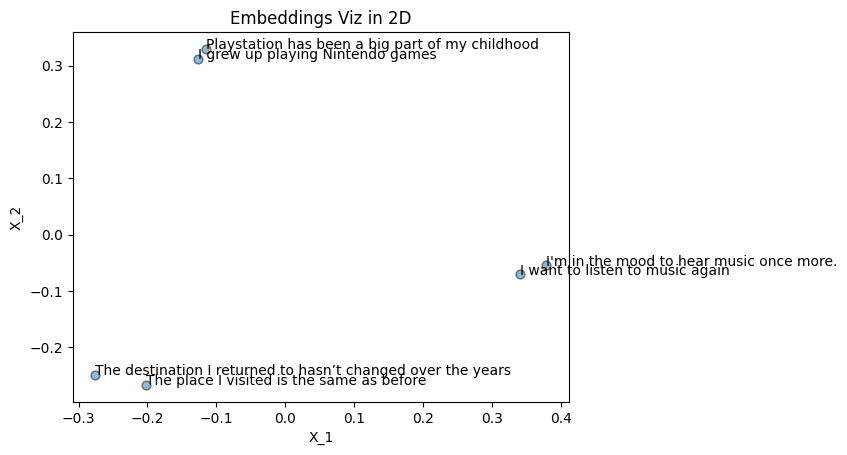

In [50]:
plot_2d(new_values[:,0], new_values[:,1], sentence_list)